In [1]:
import quandl
import zipline
import pandas as pd
from zipline.api import record, symbol, order_target_percent, order
from zipline import run_algorithm
from zipline.finance import commission, slippage
from datetime import datetime
import pytz
# silence warnings
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
%load_ext zipline


In [3]:
%zipline --start=2000-1-1 --end=2018-1-1 -b quantopian-quandl


,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,ending_value,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2000-01-03 21:00:00+00:00,NaN,0.0,NaN,4.462677e-03,NaN,NaN,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,1,[],0.0
2000-01-04 21:00:00+00:00,0.0,0.0,NaN,8.945269e-03,0.000000,NaN,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,2,[],0.0
2000-01-05 21:00:00+00:00,0.0,0.0,NaN,1.344787e-02,0.000000,NaN,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,3,[],0.0
2000-01-06 21:00:00+00:00,0.0,0.0,NaN,1.797056e-02,0.000000,NaN,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,4,[],0.0
2000-01-07 21:00:00+00:00,0.0,0.0,NaN,2.251343e-02,0.000000,NaN,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,5,[],0.0
2000-01-10 21:00:00+00:00,0.0,0.0,NaN,2.707658e-02,0.000000,NaN,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,6,[],0.0
2000-01-11 21:00:00+00:00,0.0,0.0,NaN,3.166009e-02,0.000000,NaN,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,7,[],0.0
2000-01-12 21:00:00+00:00,0.0,0.0,NaN,3.626405e-02,0.000000,NaN,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,8,[],0.0
2000-01-13 21:00:00+00:00,0.0,0.0,NaN,4.088856e-02,0.000000,NaN,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,9,[],0.0
2000-01-14 21:00:00+00:00,0.0,0.0,NaN,4.553371e-02,0.000000,NaN,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,10,[],0.0


In [4]:
from talib import EMA


In [18]:
def initialize(context):
    context.asset = symbol('AMZN')

    # To keep track of whether we invested in the stock or not
    context.invested = False

    # Explicitly set the commission/slippage to the "old" value until we can
    # rebuild example data.
    # github.com/quantopian/zipline/blob/master/tests/resources/
    # rebuild_example_data#L105
    context.set_commission(commission.PerShare(cost=.0075, min_trade_cost=1.0))
    context.set_slippage(slippage.VolumeShareSlippage())

In [19]:
def handle_data(context, data):
    trailing_window = data.history(context.asset, 'price', 40, '1d')
    if trailing_window.isnull().values.any():
        return
    short_ema = EMA(trailing_window.values, timeperiod=20)
    long_ema = EMA(trailing_window.values, timeperiod=40)

    buy = False
    sell = False

    if (short_ema[-1] > long_ema[-1]) and not context.invested:
        order(context.asset, 100)
        context.invested = True
        buy = True
    elif (short_ema[-1] < long_ema[-1]) and context.invested:
        order(context.asset, -100)
        context.invested = False
        sell = True

    record(AMZN=data.current(context.asset, "price"),
           short_ema=short_ema[-1],
           long_ema=long_ema[-1],
           buy=buy,
           sell=sell)

In [20]:
def analyze(context=None, results=None):
    import matplotlib.pyplot as plt
    import logbook
    logbook.StderrHandler().push_application()
    log = logbook.Logger('Algorithm')

    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    results.portfolio_value.plot(ax=ax1)
    ax1.set_ylabel('Portfolio value (USD)')

    ax2 = fig.add_subplot(212)
    ax2.set_ylabel('Price (USD)')

    # If data has been record()ed, then plot it.
    # Otherwise, log the fact that no data has been recorded.
    if 'AMZN' in results and 'short_ema' in results and 'long_ema' in results:
        results[['AMZN', 'short_ema', 'long_ema']].plot(ax=ax2)

        ax2.plot(
            results.index[results.buy],
            results.loc[results.buy, 'long_ema'],
            '^',
            markersize=10,
            color='m',
        )
        ax2.plot(
            results.index[results.sell],
            results.loc[results.sell, 'short_ema'],
            'v',
            markersize=10,
            color='k',
        )
        plt.legend(loc=0)
        plt.gcf().set_size_inches(18, 12)
    else:
        msg = 'Amazon, short_ema and long_ema data not captured using record().'
        ax2.annotate(msg, xy=(0.1, 0.5))
        log.info(msg)

    plt.show()

[2018-09-15 17:37:50.824377] WARNING: Loader: Refusing to download new benchmark data because a download succeeded at 2018-09-15 17:17:40.857382+00:00.
[2018-09-15 17:37:57.811986] INFO: zipline.finance.metrics.tracker: Simulated 2013 trading days
first open: 2010-01-04 14:31:00+00:00
last close: 2017-12-29 21:00:00+00:00


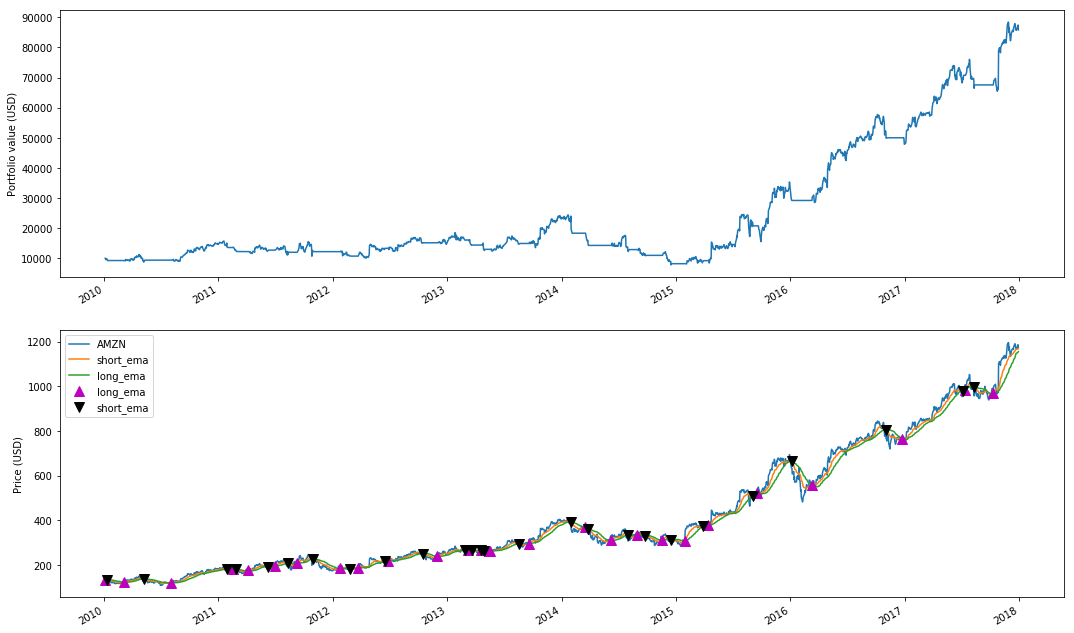

In [21]:
import matplotlib.pyplot as plt
# Set up the stuff for running the trading simulation
base_capital = 10000
start = datetime(2010, 1, 1, 0, 0, 0, 0, pytz.utc)
end = datetime(2018, 1, 1, 0, 0, 0, 0, pytz.utc)
# run the trading algorithm and save the results in perf
perf = run_algorithm(start, end, initialize, base_capital, handle_data,
        bundle = 'quantopian-quandl', analyze=analyze)

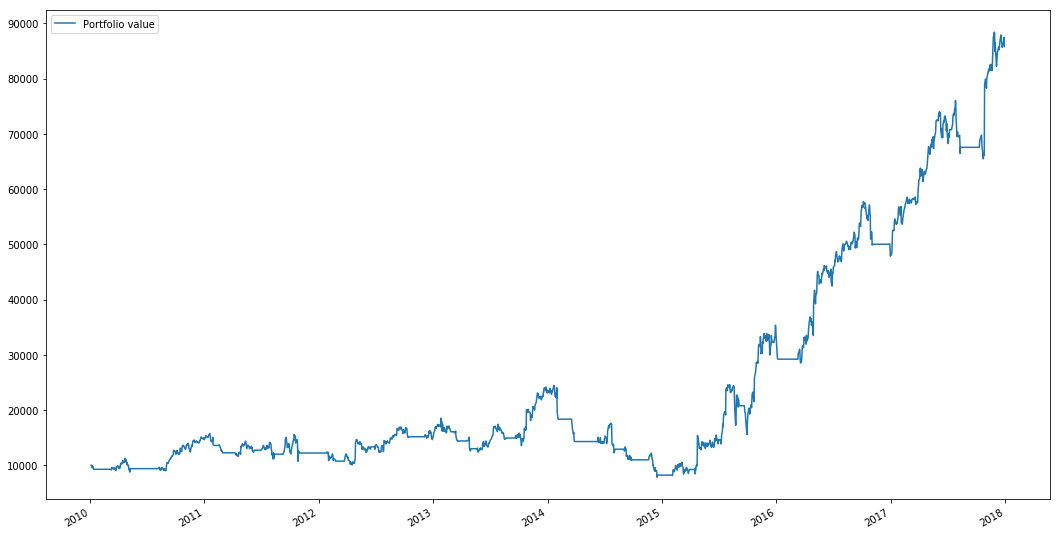

In [24]:
# Draw a nice plot of the value of our portfolio and save it
import matplotlib.pyplot as plt
plt.figure(figsize=(18,10))
perf.portfolio_value.plot(label="Portfolio value")
# This is was generated by the run_algorithm
plt.legend()
plt.savefig('returns_appl.png')


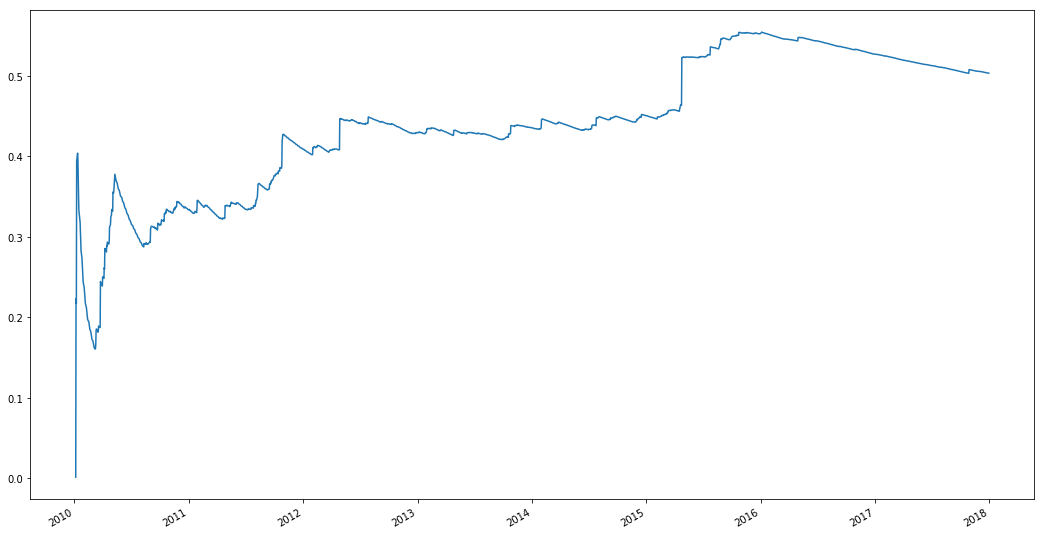

In [29]:
plt.figure(figsize=(18,10))
perf.algo_volatility.plot(label="Volatility")

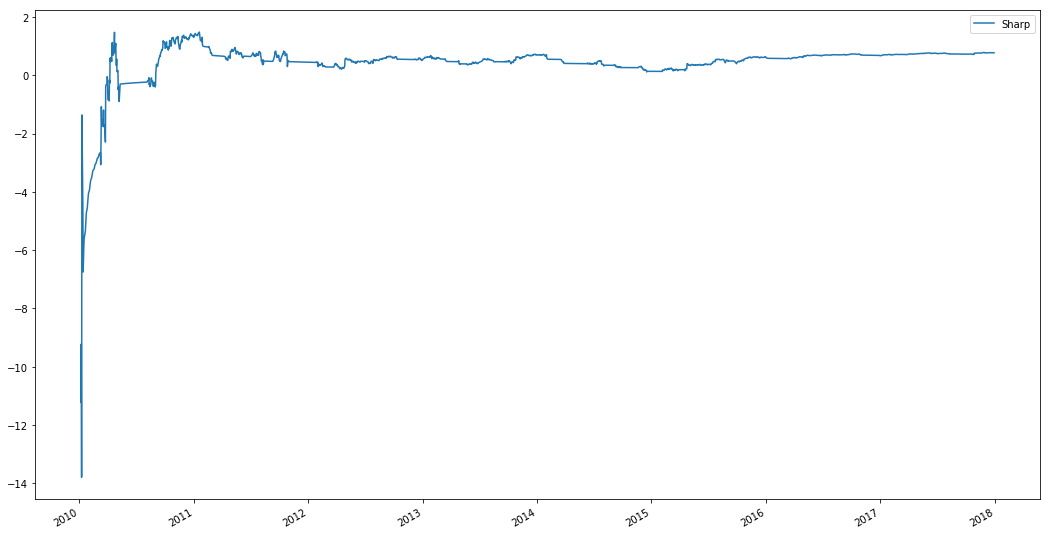

In [31]:
plt.figure(figsize=(18,10))
perf.sharpe.plot(label="Sharp")
plt.legend()

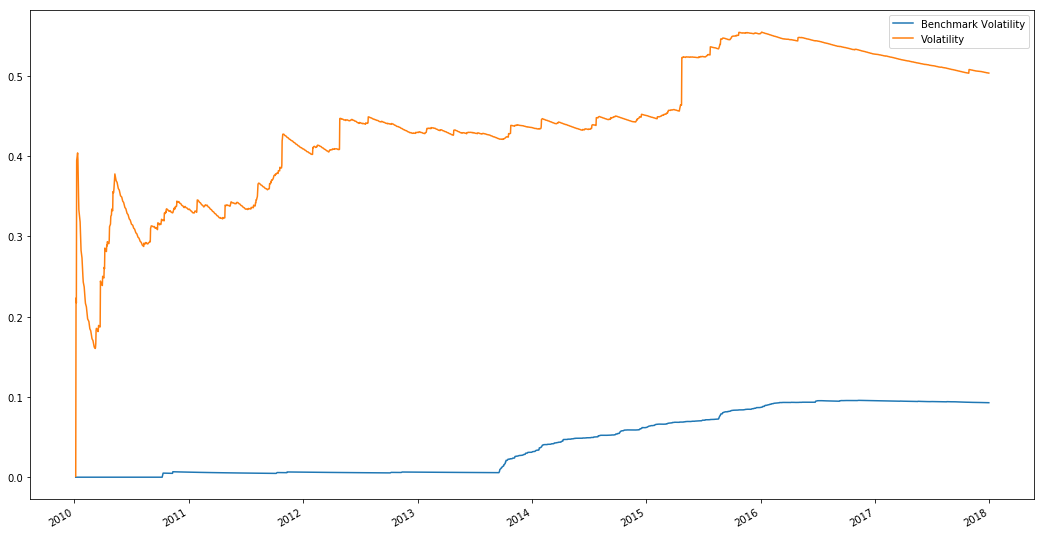

In [33]:
plt.figure(figsize=(18,10))
perf.benchmark_volatility.plot(label="Benchmark Volatility")
perf.algo_volatility.plot(label="Volatility")
plt.legend()